# Pylops - Least squares microseismic location

### Author: M.Ravasi

In this notebook I will show you how to perform least-squares microseismic location with a Kirchoff modelling operator.

The modelling is simply expressed by the following equation

$$ d(r, t) = w(t) * \int_V G(r,s, t) s(x,z) dx dz$$

where $s(x, z)$ is our model and it represents the microseismic source strenght at every location in the subsurface, $G(r,s, t)$ is the Green's functions from microseismic source to receiver and finally $w$ is the wavelet.

In a matrix for

$$ \mathbf{d} = \mathbf{W} \mathbf{G} \mathbf{s}$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## 2D layered in homogenous velocity

Lets' create a model and geometry

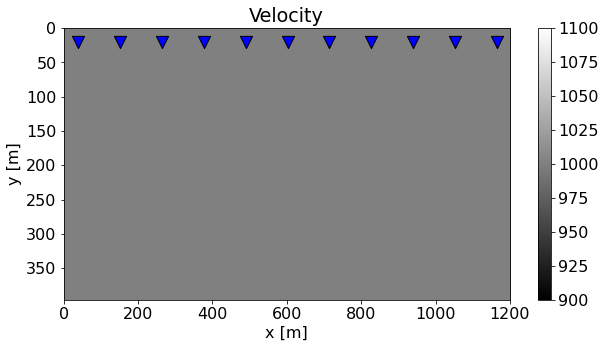

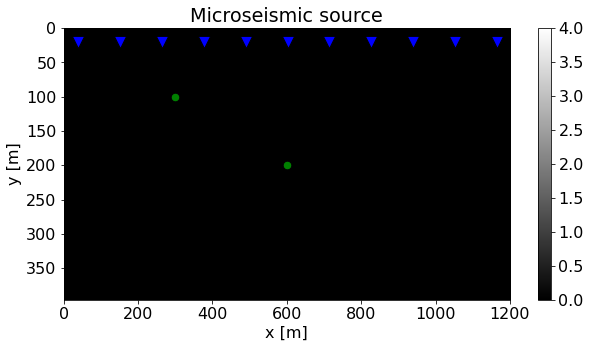

In [2]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Microseismic source
xmicro = [nx//2, nx//4]
zmicro = [nz//2, nz//4]
ampmicro = [1, 4]
microseismic = np.zeros((nx, nz))
for ix, iz, amp in zip(xmicro, zmicro, ampmicro):
    microseismic[ix, iz] = amp

# Receivers
nr = 11
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(microseismic.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[xmicro], z[zmicro], marker='.', s=300, c='g', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Microseismic source')
plt.xlim(x[0], x[-1]);

Compute traveltimes for homogenous medium

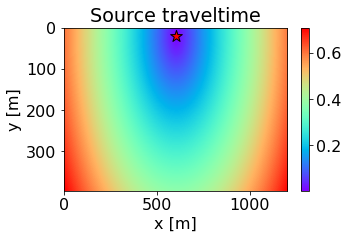

In [3]:
trav = Kirchhoff._traveltime_table(z, x, recs, recs, v0, mode='analytic')[1]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
im = ax.imshow(trav[:, nr//2].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, nr//2], recs[1, nr//2], marker='*', s=150, c='r', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Source traveltime')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

Finally we model the data and invert it

In [4]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, nr)
travd = travd.reshape(nx, nz, nr)

In [5]:
# create operator
sop = Spread(dims=(nx, nz), dimsd=(nr, nt),
             table=itrav, dtable=travd, engine='numba')

cop = Convolve1D(h=wav, offset=wavc,
                 dims=(nr, nt), axis=1)
Demop = cop * sop


d = Demop * microseismic.ravel()
d = d.reshape(nr, nt)

madj = Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsqr(Demop, d.ravel(), iter_lim=100, show=True)[0]
minv = minv.reshape(nx, nz)

minv_sparse = fista(Demop, d.ravel(), niter=100, eps=1e1, show=True)[0]
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = Demop * madj.ravel()
dadj = dadj.reshape(nr, nt)

dinv = Demop * minv.ravel()
dinv = dinv.reshape(nr, nt)

dinv_sparse = Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(nr, nt)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 7161 rows and 30100 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.638e+01  2.638e+01    1.0e+00  2.5e+00
     1 -5.20601e-04   1.575e+01  1.575e+01    6.0e-01  6.5e-01   8.2e+01  1.0e+00
     2 -1.59392e-03   1.016e+01  1.016e+01    3.9e-01  4.6e-01   1.1e+02  2.3e+00
     3 -2.51566e-03   7.478e+00  7.478e+00    2.8e-01  2.9e-01   1.4e+02  3.7e+00
     4 -2.64552e-03   5.699e+00  5.699e+00    2.2e-01  2.4e-01   1.6e+02  5.3e+00
     5 -2.84195e-03   4.523e+00  4.523e+00    1.7e-01  1.8e-01   1.8e+02  7.0e+00
     6 -2.82997e-03   3.786e+00  3.786e+00    1.4e-01  1.6e-01   2.0e+02  8.7e+00
     7 -2.66608e-03   3.236e+00  3.236e+00    1.2e-01  1.4e-01   2.1e+02  1.1e+01
     8 -2.69278e-03   2.783e+00  

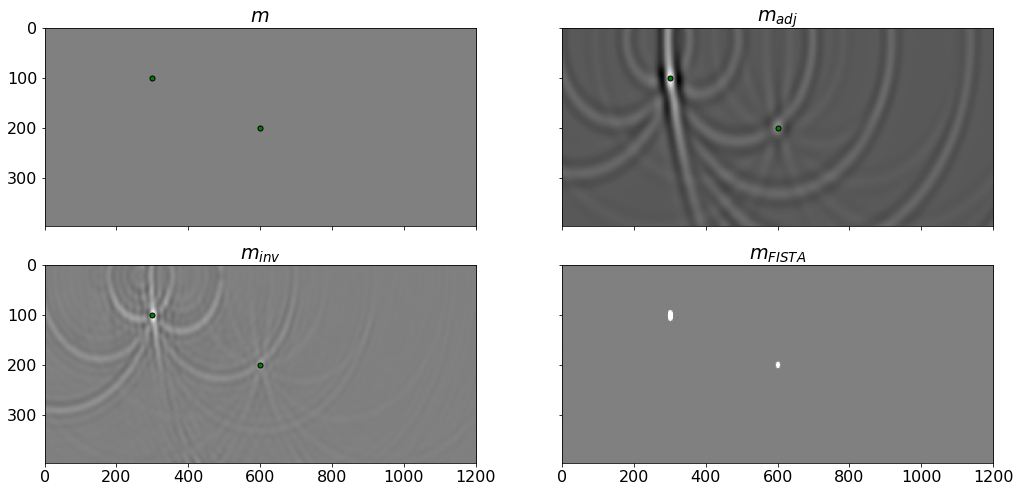

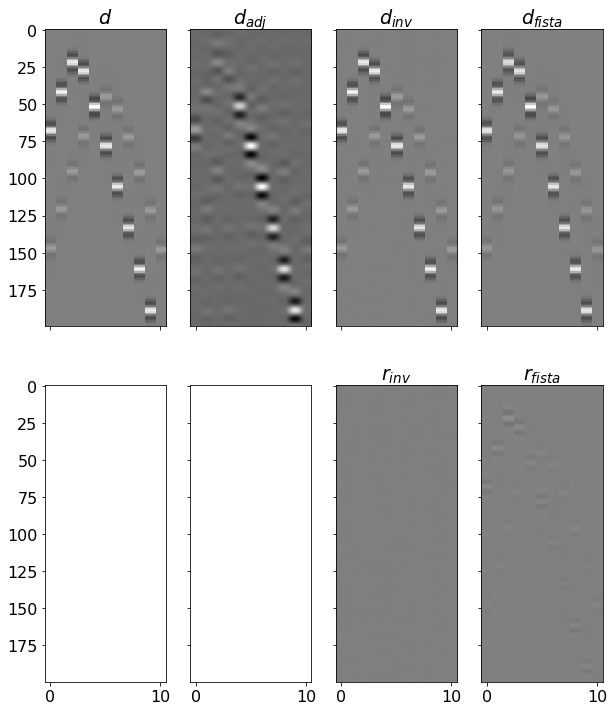

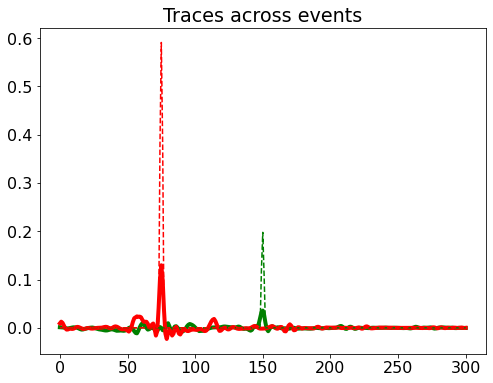

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(17, 8), sharey=True, sharex=True)
axs[0][0].imshow(microseismic.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
axs[0][0].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
axs[0][1].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
axs[1][0].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray', vmin=-0.1, vmax=0.1, extent = (x[0], x[-1], z[-1], z[0]))
#axs[1][1].scatter(x[xmicro], z[zmicro], marker='.', s=100, c='g', edgecolors='k')
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(2, 4, figsize=(10, 12), sharey=True, sharex=True)
axs[0][0].imshow(d[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[0][0].set_title(r'$d$')
axs[0][0].axis('tight')
axs[0][1].imshow(dadj[:, :200].T, cmap='gray')
axs[0][1].set_title(r'$d_{adj}$')
axs[0][1].axis('tight')
axs[0][2].imshow(dinv[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[0][2].set_title(r'$d_{inv}$')
axs[0][2].axis('tight');
axs[0][3].imshow(dinv_sparse[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[0][3].set_title(r'$d_{fista}$')
axs[0][3].axis('tight');
axs[1][2].imshow(d[:, :200].T-dinv[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[1][2].set_title(r'$r_{inv}$')
axs[1][2].axis('tight');
axs[1][3].imshow(d[:, :200].T-dinv_sparse[:, :200].T, cmap='gray', vmin=-d.max(), vmax=d.max(), interpolation='none')
axs[1][3].set_title(r'$r_{fista}$')
axs[1][3].axis('tight')

plt.figure()
plt.plot(minv[:, zmicro[0]], 'g', lw=4)
plt.plot(minv[:, zmicro[1]], 'r', lw=4)
plt.plot(minv_sparse[:, zmicro[0]], '--g')
plt.plot(minv_sparse[:, zmicro[1]], '--r')
plt.title('Traces across events');

## Marmousi model

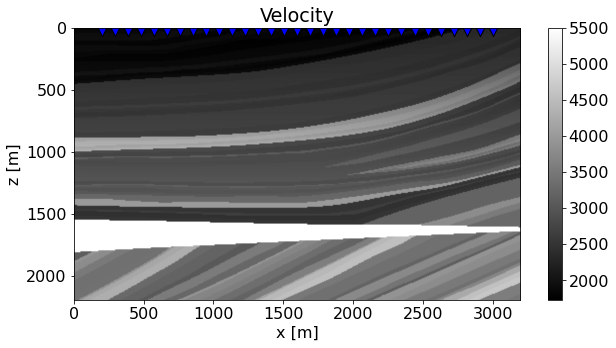

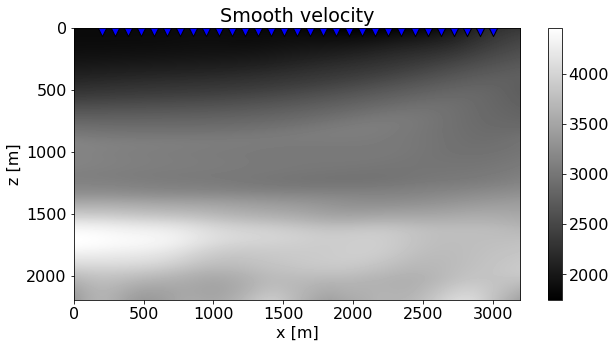

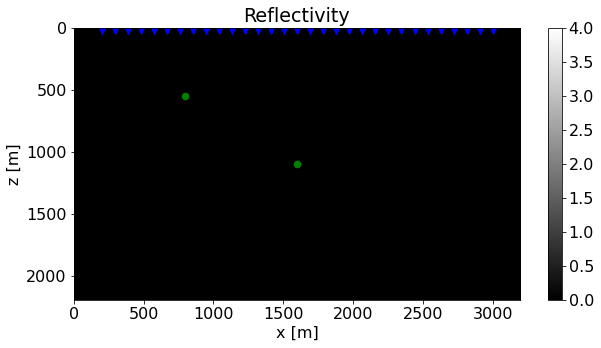

In [7]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
nx, nz = len(x), len(z)

# Microseismic source
xmicro = [nx//2, nx//4]
zmicro = [nz//2, nz//4]
ampmicro = [1, 4]
microseismic = np.zeros((nx, nz))
for ix, iz, amp in zip(xmicro, zmicro, ampmicro):
    microseismic[ix, iz] = amp

# Smooth velocity
nsmooth=100
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel, axis=1)

# Receivers
nr = 31
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('z [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('z [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(microseismic.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[xmicro], z[zmicro], marker='.', s=300, c='g', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('z [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0]);


Compute traveltimes with eikonal

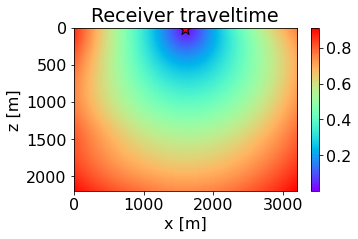

In [8]:
trav = Kirchhoff._traveltime_table(z, x, recs, recs, vel, mode='eikonal')[1]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
im = ax.imshow(trav[:, nr//2].reshape((nx, nz)).T, cmap='rainbow',
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, nr//2], recs[1, nr//2], marker='*', s=150, c='r', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_title('Receiver traveltime')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

Create data and invert model

In [9]:
nt = 751
dt = 0.004
t = np.arange(nt)*dt

itrav = (np.floor(trav/dt)).astype(np.int32)
travd = (trav/dt - itrav)
itrav = itrav.reshape(nx, nz, nr)
travd = travd.reshape(nx, nz, nr)

# create operator
sop = Spread(dims=(nx, nz), dimsd=(nr, nt),
             table=itrav, dtable=travd, engine='numba')

cop = Convolve1D(h=wav, offset=wavc,
                 dims=(nr, nt), axis=1)
Demop = cop * sop

d = Demop * microseismic.ravel()
d = d.reshape(nr, nt)

madj = Demop.H * d.ravel()
madj = madj.reshape(nx, nz)

minv = lsqr(Demop, d.ravel(), iter_lim=100, show=True)[0]
minv = minv.reshape(nx, nz)

minv_sparse = fista(Demop, d.ravel(), niter=100, eps=1e1, show=True)[0]
minv_sparse = minv_sparse.reshape(nx, nz)

# demigration
dadj = Demop * madj.ravel()
dadj = dadj.reshape(nr, nt)

dinv = Demop * minv.ravel()
dinv = dinv.reshape(nr, nt)

dinv_sparse = Demop * minv_sparse.ravel()
dinv_sparse = dinv_sparse.reshape(nr, nt)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 23281 rows and 440000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.320e+01  4.320e+01    1.0e+00  4.7e+00
     1 -2.87055e-05   2.694e+01  2.694e+01    6.2e-01  7.6e-01   2.6e+02  1.0e+00
     2 -4.23475e-05   1.953e+01  1.953e+01    4.5e-01  3.9e-01   4.2e+02  2.3e+00
     3 -3.21153e-05   1.466e+01  1.466e+01    3.4e-01  3.3e-01   5.2e+02  3.8e+00
     4 -3.98818e-06   1.159e+01  1.159e+01    2.7e-01  2.6e-01   6.2e+02  5.5e+00
     5  3.01489e-05   9.621e+00  9.621e+00    2.2e-01  2.0e-01   7.1e+02  7.3e+00
     6  5.99544e-05   8.331e+00  8.331e+00    1.9e-01  1.8e-01   7.9e+02  9.1e+00
     7  8.72970e-05   7.128e+00  7.128e+00    1.6e-01  1.4e-01   8.7e+02  1.1e+01
     8  1.03450e-04   6.068e+00

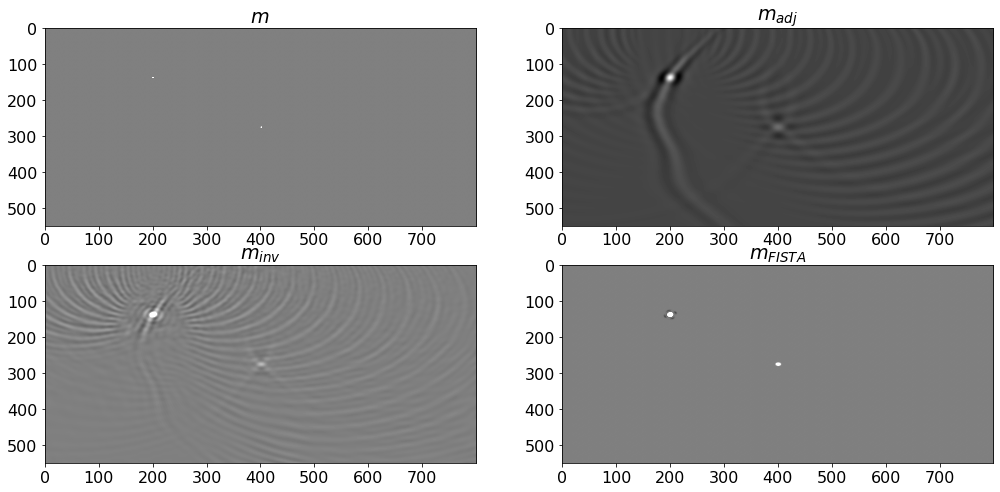

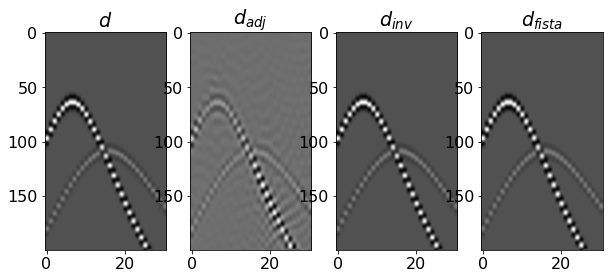

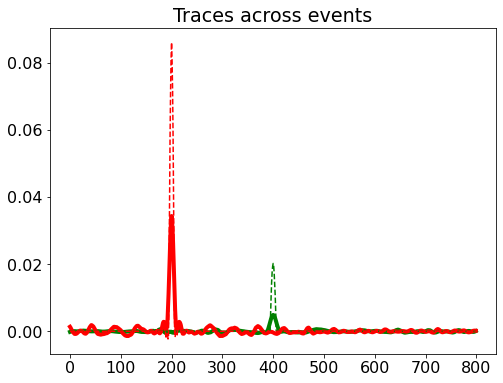

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(17, 8))
axs[0][0].imshow(microseismic.T, cmap='gray', vmin=-0.06, vmax=.06)
axs[0][0].axis('tight')
axs[0][0].set_title(r'$m$')
axs[0][1].imshow(madj.T, cmap='gray')
axs[0][1].set_title(r'$m_{adj}$')
axs[0][1].axis('tight')
axs[1][0].imshow(minv.T, cmap='gray', vmin=-0.01, vmax=.01)
axs[1][0].axis('tight')
axs[1][0].set_title(r'$m_{inv}$');
axs[1][1].imshow(minv_sparse.T, cmap='gray', vmin=-0.01, vmax=.01)
axs[1][1].axis('tight')
axs[1][1].set_title(r'$m_{FISTA}$');

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(d[:, :200].T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(dadj[:, :200].T, cmap='gray')
axs[1].set_title(r'$d_{adj}$')
axs[1].axis('tight')
axs[2].imshow(dinv[:, :200].T, cmap='gray')
axs[2].set_title(r'$d_{inv}$')
axs[2].axis('tight');
axs[3].imshow(dinv_sparse[:, :200].T, cmap='gray')
axs[3].set_title(r'$d_{fista}$')
axs[3].axis('tight');

plt.figure()
plt.plot(minv[:, zmicro[0]], 'g', lw=4)
plt.plot(minv[:, zmicro[1]], 'r', lw=4)
plt.plot(minv_sparse[:, zmicro[0]], '--g')
plt.plot(minv_sparse[:, zmicro[1]], '--r')
plt.title('Traces across events');